# Domain Analysis

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import sys
sys.path.append("../..")

In [2]:
import asyncio
from collections import defaultdict
import ipaddress
import os.path

import matplotlib
import networkx as nx

matplotlib.rcParams['figure.figsize'] = (9.5, 8)

## Load Full DNS Graph

In [3]:
from netanalysis.analysis.analysis_app import AnalysisApp

app = AnalysisApp(os.path.join(os.getcwd(), "..", "..", "ooni_data"))

IntProgress(value=0, description='Loading')

## Create Domain Graph

In [4]:
domain_app = app.domain_app("www.match.com")
print("Graph nodes: %s" % ", ".join(sorted(domain_app.domain_graph.nodes)))
print("Parent domains: %s" % (set(nx.dfs_preorder_nodes(app.dns_graph.reverse(copy=False), domain_app.domain)) - set([domain_app.domain])))

Graph nodes: 0.0.0.0/24, 10.10.34.0/24, 127.10.0.0/24, 146.112.61.0/24, 208.83.240.0/24, 208.83.242.0/24, 212.73.212.0/24, 212.73.228.0/24, 62.23.26.0/24, 62.23.30.0/24, 90.207.238.0/24, ar.latam-match.com.akadns.net, at-v6.meetic.com.akadns.net, at.europe.match.com, at.match.com, be-v6.meetic.com.akadns.net, be.europe.match.com, be.match.com, br.latam-match.com.akadns.net, br.match.com, ch-v6.meetic.com.akadns.net, ch.europe.match.com, ch.match.com, cl.latam-match.com.akadns.net, cl.match.com, de-v6.meetic.com.akadns.net, de.europe.match.com, de.match.com, es-v6.meetic.com.akadns.net, es.europe.match.com, es.match.com, europe.match.com, fi.europe.match.com, fi.match.com, fr-v6.meetic.com.akadns.net, fr.europe.match.com, fr.match.com, it-v6.meetic.com.akadns.net, it.europe.match.com, it.match.com, match.com.mx, match.com.ve, nl-u4-matchaffinity.meetic.com.akadns.net, nl.europe.match.com, nl.match.com, no.europe.match.com, no.match.com, se.europe.match.com, se.match.com, uk-dating-fulls

## Classify Edges

<IPython.core.display.Javascript object>


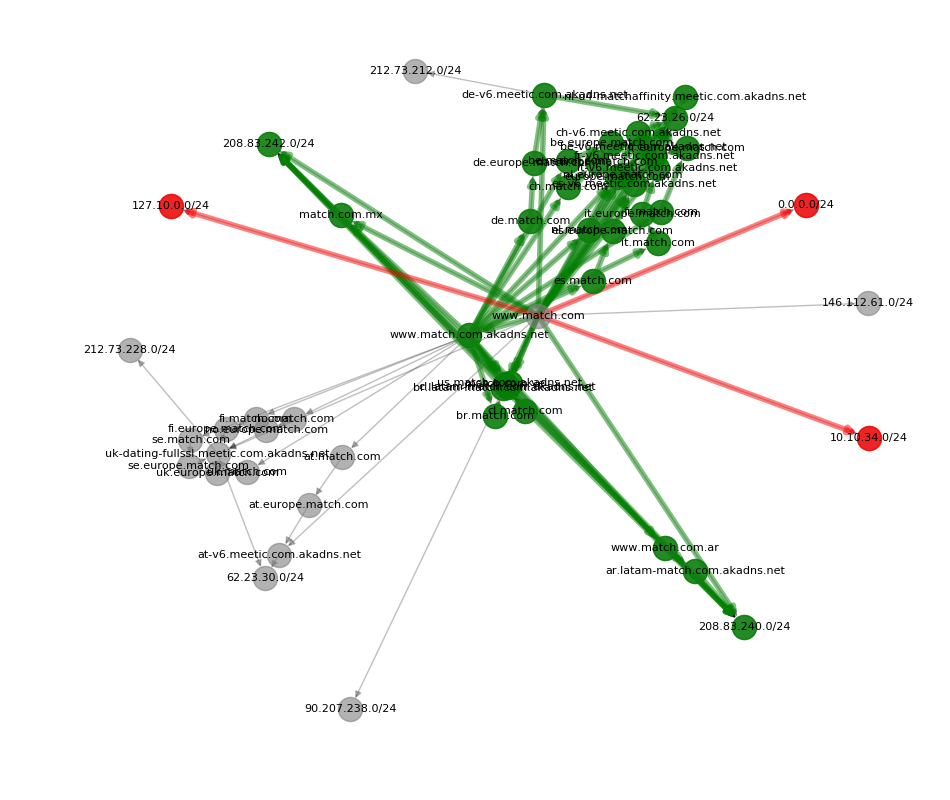

In [5]:
domain_app.display_graph()

## Use TLS to verify UNKNOWNs

At this stage we use TLS validation of certificates to check if an IP is valid for a domain

Checking IPs for de.match.com - 212.73.212.0/24
    Validating 212.73.212.91: VALID
Checking IPs for se.match.com - 212.73.228.0/24
    Validating 212.73.228.29: VALID
Checking IPs for fi.match.com - 212.73.228.0/24
    Validating 212.73.228.29: VALID
Checking IPs for no.match.com - 212.73.228.0/24
    Validating 212.73.228.29: VALID
Checking IPs for uk.match.com - 212.73.228.0/24
    Validating 212.73.228.29: VALID
Checking IPs for se.match.com - 62.23.30.0/24
    Validating 62.23.30.24: ConnectionRefusedError(61, "Connect call failed ('62.23.30.24', 443)")
    Validating 62.23.30.26: VALID
Checking IPs for at.match.com - 62.23.30.0/24
    Validating 62.23.30.24: ConnectionRefusedError(61, "Connect call failed ('62.23.30.24', 443)")
    Validating 62.23.30.26: VALID
Checking IPs for www.match.com - 146.112.61.0/24
    Validating 146.112.61.106: SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:777)')
Checking IPs for www.match.com - 212.73.228.0/24
    Va

<IPython.core.display.Javascript object>


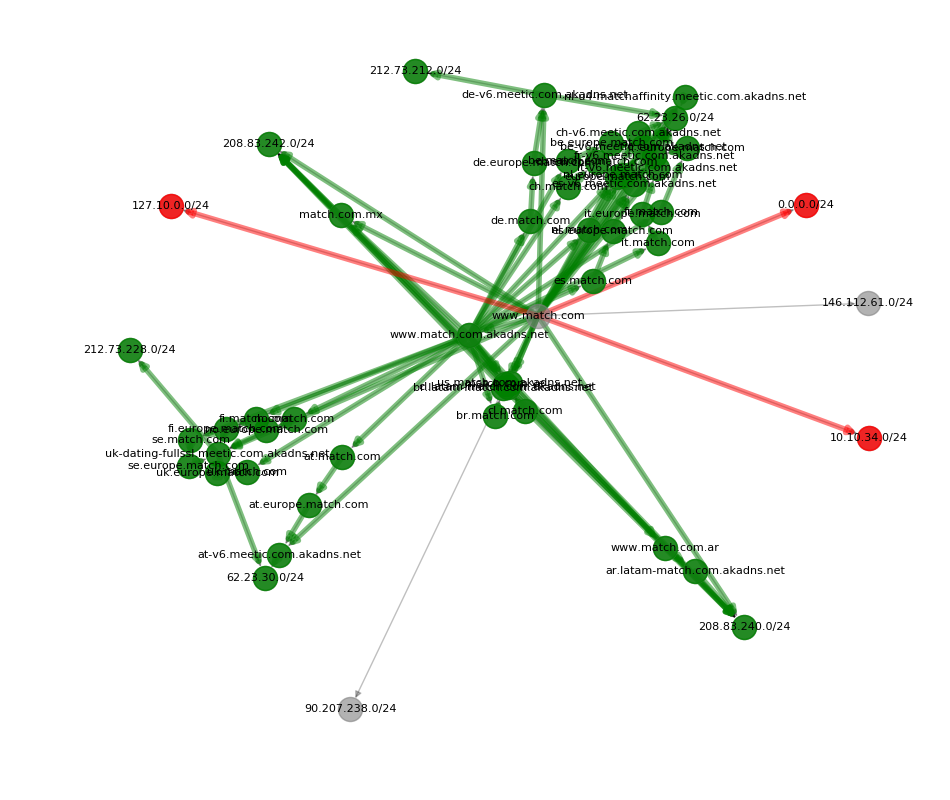

In [6]:
asyncio.get_event_loop().run_until_complete(domain_app.tls_verify_unknowns())
domain_app.display_graph()

## Classify Measurements

In [7]:
from netanalysis.dns import classifier as dc

def analyze_measurements(domain: str, domain_graph, class_graph, results=None):
    measurements = dict()  # type: Dict[str, dns.DnsMeasurement]
    for u, v, data in domain_graph.edges(data=True):
        measurement = data.get("measurement")
        if not measurement:
            continue
        if measurement.trust_reason:
            continue
        if measurement.records[0].name.lower() != domain:
            continue
        measurements[measurement.measurement_id] = measurement


    for measurement in sorted(measurements.values(), key=lambda m: m.time):
        measurement_eval = dc.Evaluation(dc.EdgeClass.UNKNOWN, None)
        ips = []
        for record in measurement.records:
            try:
                ip = record.data.ip
                ips.append(ip)
            except AttributeError:
                continue
            
        for ip in ips:
            net = str(ipaddress.ip_network(ip).supernet(new_prefix=24))
            evaluation = class_graph[domain][net]["eval"]
            if evaluation.classification != dc.EdgeClass.UNKNOWN:
                measurement_eval = evaluation
                break
        if not results or measurement_eval.classification in results:
            print("{} {} {}, IPs: [{}] (DNS: {})".format(
                measurement.time,
                measurement.client_country,
                measurement_eval.classification.name,
                ", ".join(str(ip) for ip in ips),
                measurement.resolver_ip
            ))

analyze_measurements(domain_app.domain,
                     domain_app.domain_graph,
                     domain_app.classifier.class_graph,
                     results=[dc.EdgeClass.UNKNOWN, dc.EdgeClass.BAD])

2018-02-18 08:45:23 GB UNKNOWN, IPs: [90.207.238.183] (DNS: 90.207.242.19)
2018-02-18 14:12:30 DE BAD, IPs: [0.0.0.0] (DNS: None)
2018-02-19 02:53:13 BO BAD, IPs: [127.10.0.1] (DNS: 200.87.100.21)
2018-02-19 19:07:28 GB UNKNOWN, IPs: [90.207.238.183] (DNS: 90.207.242.11)
2018-02-20 03:40:48 BO BAD, IPs: [127.10.0.1] (DNS: 83.223.39.126)
2018-02-20 13:44:38 DE BAD, IPs: [0.0.0.0] (DNS: 74.63.24.247)
2018-02-21 03:09:44 DE BAD, IPs: [0.0.0.0] (DNS: 74.63.24.242)
2018-02-21 04:08:12 BO BAD, IPs: [127.10.0.1] (DNS: 200.87.100.21)
2018-02-21 18:55:45 GB UNKNOWN, IPs: [90.207.238.183] (DNS: 90.207.242.18)
2018-02-22 03:46:55 BO BAD, IPs: [127.10.0.1] (DNS: 200.87.100.21)
2018-02-22 18:38:20 DE BAD, IPs: [0.0.0.0] (DNS: 74.63.24.244)
2018-02-22 18:55:24 GB UNKNOWN, IPs: [90.207.238.183] (DNS: 90.207.242.22)
2018-02-23 01:27:18 BO BAD, IPs: [127.10.0.1] (DNS: 74.125.177.10)
2018-02-23 04:18:00 IR BAD, IPs: [10.10.34.35] (DNS: 74.125.181.13)
2018-02-23 09:22:20 GB UNKNOWN, IPs: [90.207.238.183]

## Analyze a country

<IPython.core.display.Javascript object>


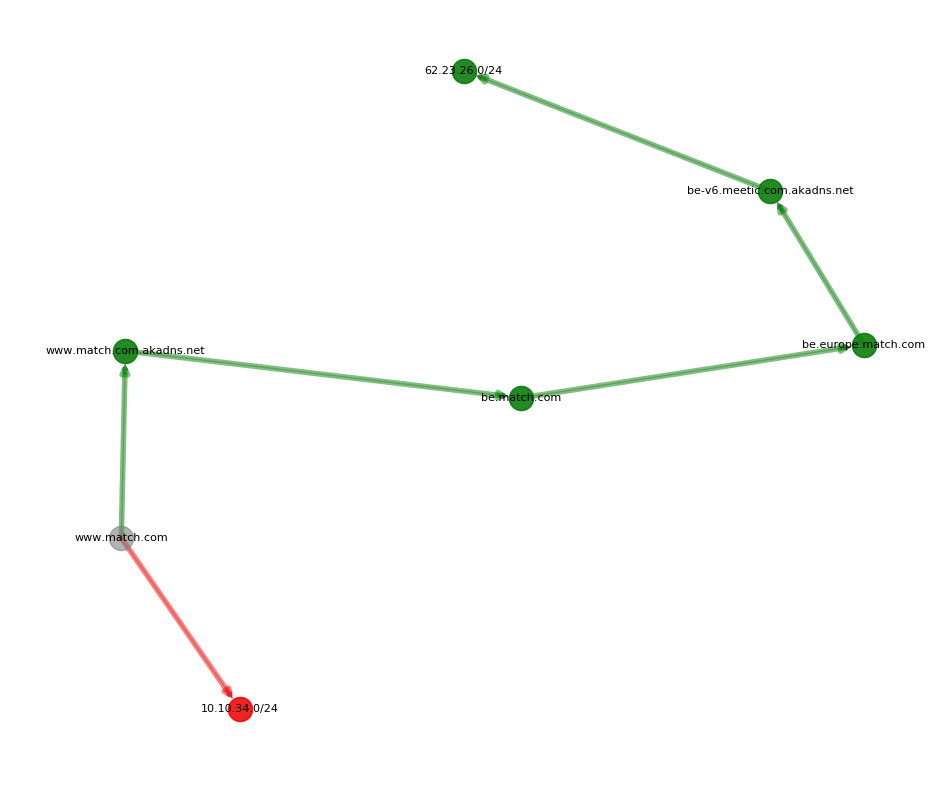

In [8]:
domain_app.display_graph(country="IR")

## Investigate an IP Address

In [9]:
from IPython.display import display
import ipywidgets as widgets
from netanalysis.analysis import ip_info_widget
from netanalysis.ip import ip_info as ii

ip_info = ii.create_default_ip_info_service()
ip_tab = ip_info_widget.create_ip_info_widget(ip_info)
tabs = widgets.Tab()
tabs.set_title(0, "IP Info")
tabs.children = [ip_tab]
tabs